# Walmart Sales Forecasting Project

## Project Overview
This project aims to predict weekly sales for Walmart stores using historical data, store information, and external economic factors. We use **XGBoost** as our primary machine learning model and **MLflow** for experiment tracking and model management.

### Objectives:
- Analyze historical sales patterns across stores and departments
- Engineer meaningful features from temporal and external data
- Build an accurate sales prediction model
- Implement MLOps best practices with MLflow

---

## 1. Import Libraries & Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.graph_objects as go
from dash import Dash, dcc, html, Input, Output
from typing import Any
import mlflow
import mlflow.entities
from mlflow.tracking import MlflowClient
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV


---

## 2. Data Loading & Initial Exploration

We'll load three datasets:
- **train.csv**: Historical weekly sales data
- **stores.csv**: Store metadata (type and size)
- **features.csv**: External factors (temperature, fuel price, CPI, unemployment)

In [2]:
df_store = pd.read_csv(r'D:\anton\DEPI\IBM Data Scientist\0- Graduation Project\project\stores.csv')

df_store.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [3]:
df_train = pd.read_csv(r'D:\anton\DEPI\IBM Data Scientist\0- Graduation Project\project\train.csv')
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df_features = pd.read_csv(r'D:\anton\DEPI\IBM Data Scientist\0- Graduation Project\project\features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


### 2.1 Data Merging
Combining all three datasets using inner joins on common keys (Store, Date, IsHoliday).

In [5]:
df = df_train.merge(df_features, on=["Store", "Date","IsHoliday"], how='inner').merge(df_store, on=['Store'], how='inner')
df.head()


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315


In [6]:
df.shape

(421570, 16)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 48.6+ MB


In [8]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Type                 0
Size                 0
dtype: int64

### 2.2 Missing Value Analysis
Analyzing missing values in the dataset, particularly in MarkDown columns which have 50-70% missing values.

In [9]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

for col in markdown_cols:
    valid_data = df[df[col].notna()]
    corr = valid_data[col].corr(valid_data['Weekly_Sales'])
    print(f"{col}: correlation = {corr:.3f}, missing = {df[col].isna().mean()*100:.1f}%")

MarkDown1: correlation = 0.085, missing = 64.3%
MarkDown2: correlation = 0.024, missing = 73.6%
MarkDown3: correlation = 0.060, missing = 67.5%
MarkDown4: correlation = 0.045, missing = 68.0%
MarkDown5: correlation = 0.090, missing = 64.1%


### 2.3 Data Cleaning
Dropping MarkDown columns due to high missing rates and low correlation with sales. Also removing negative/zero sales records.

In [10]:
markdown_cols = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
df = df.drop(columns=markdown_cols)

In [11]:
print(f"Number of unique stores: {df['Store'].nunique()}")
print(f"Number of unique departments: {df['Dept'].nunique()}")

Number of unique stores: 45
Number of unique departments: 81


In [12]:
num_negative_sales = (df['Weekly_Sales'] <= 0).sum()
print(f"Number of negative or zero sales: {num_negative_sales}")

Number of negative or zero sales: 1358


In [13]:
df = df.loc[df['Weekly_Sales'] > 0]

In [14]:
df.shape

(420212, 11)

---

## 3. Feature Engineering

### 3.1 Holiday Features
Creating binary flags for major US holidays that significantly impact retail sales.

In [15]:
holiday_dates = {
    'Labor_Day': ['2010-09-10', '2011-09-09', '2012-09-07'],
    'Super_Bowl': ['2010-02-12', '2011-02-11', '2012-02-10'],
    'Thanksgiving': ['2010-11-26', '2011-11-25'],
    'Christmas': ['2010-12-31', '2011-12-30']
}

for holiday, dates in holiday_dates.items():
    df[holiday] = df['Date'].isin(dates)


In [16]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Labor_Day,Super_Bowl,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,False,True,False,False
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,False,False,False,False
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,False,False,False,False
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,False,False,False,False


---

## 4. Exploratory Data Analysis (EDA)

### 4.1 Holiday Impact Analysis
Visualizing how holidays affect weekly sales.

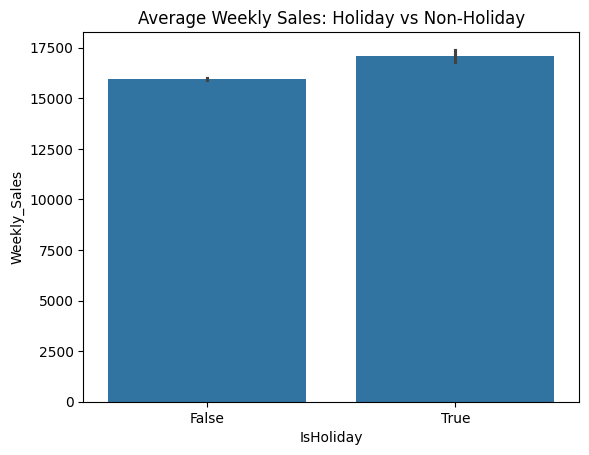

In [17]:
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.show()


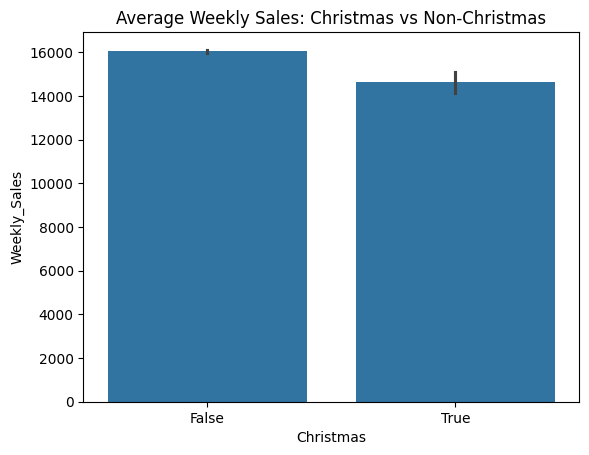

In [18]:
sns.barplot(x='Christmas', y='Weekly_Sales', data=df)   
plt.title('Average Weekly Sales: Christmas vs Non-Christmas')
plt.show()

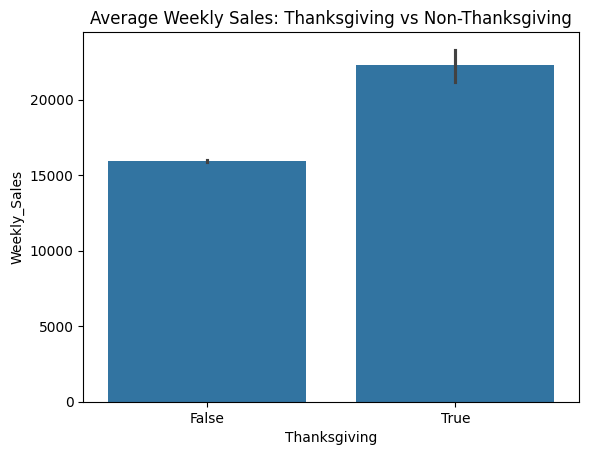

In [19]:
sns.barplot(x='Thanksgiving', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales: Thanksgiving vs Non-Thanksgiving')
plt.show()

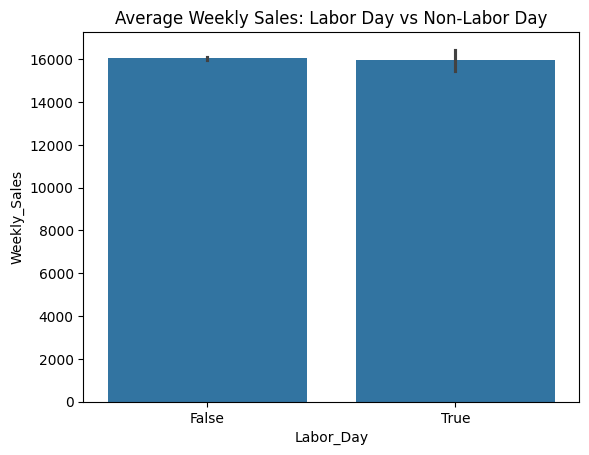

In [20]:
sns.barplot(x='Labor_Day', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales: Labor Day vs Non-Labor Day')
plt.show()

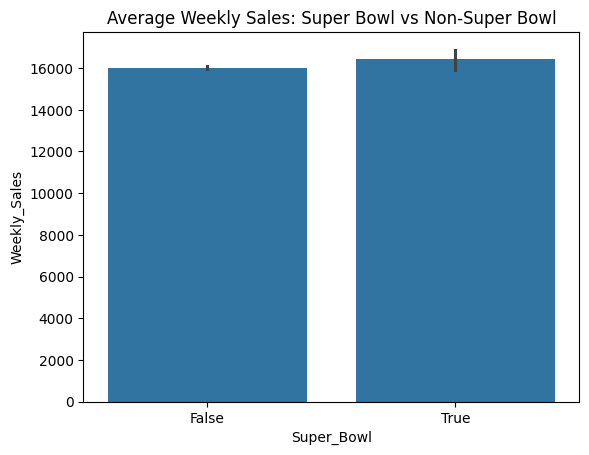

In [21]:
sns.barplot(x='Super_Bowl', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales: Super Bowl vs Non-Super Bowl')
plt.show()

### 4.2 Holiday Sales by Store Type
Analyzing how different store types perform during holidays.

            Thanksgiving    Super_Bowl     Labor_Day     Christmas
      Type                                                        
False A     20044.007801  20138.055908  20151.210941  20174.350209
      B     12197.717405  12286.739293  12294.954138  12301.986116
      C      9547.377807   9536.110508   9542.098293   9570.951973
True  A     27397.776346  20612.757674  20004.267422  18310.167535
      B     18733.973971  12467.035506  12084.304642  11488.988057
      C      9696.566616  10179.271884   9893.459258   8031.520607


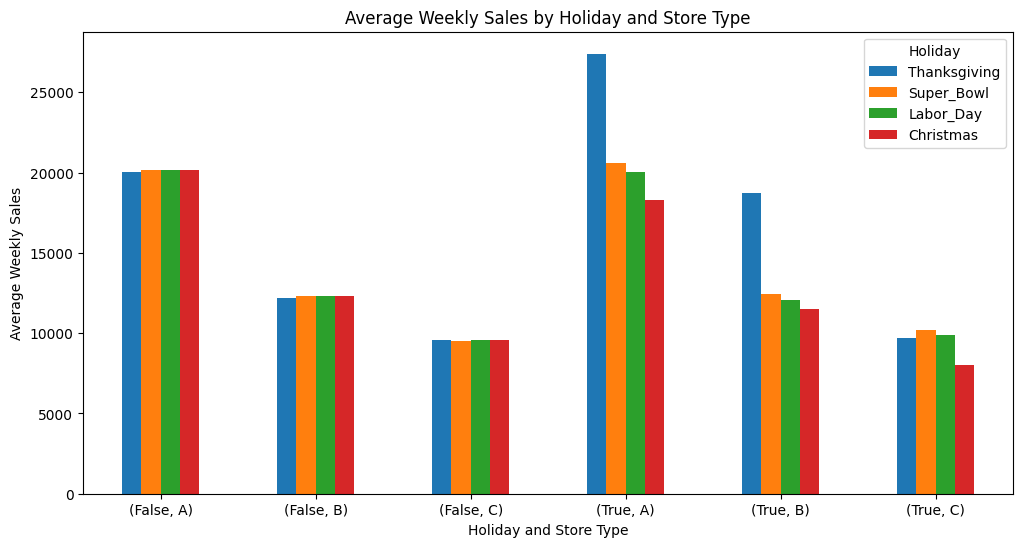

In [17]:
holidays = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']
combined_summary = pd.concat(
    {
         holiday: df.groupby([holiday, 'Type'])['Weekly_Sales'].mean()
        for holiday in holidays }
    , axis=1 )

print(combined_summary)
combined_summary.plot(kind='bar', figsize=(12, 6))
plt.title('Average Weekly Sales by Holiday and Store Type')
plt.ylabel('Average Weekly Sales')
plt.xticks(rotation=0)
plt.xlabel('Holiday and Store Type')
plt.legend(title='Holiday')
plt.show()

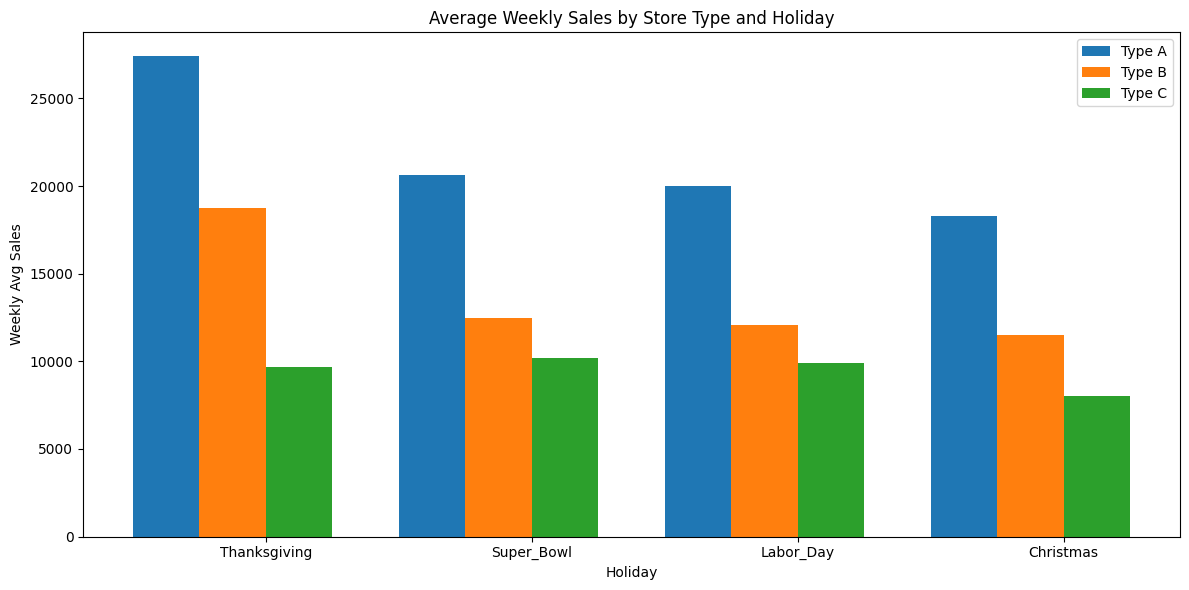

In [18]:

holidays = ['Thanksgiving', 'Super_Bowl', 'Labor_Day', 'Christmas']

type_means = {
    holiday: df[df[holiday] == True].groupby('Type')['Weekly_Sales'].mean()
    for holiday in holidays
}

labels = holidays
store_types = sorted(df['Type'].unique())
x = np.arange(len(labels))
width = 0.25


fig, ax = plt.subplots(figsize=(12, 6))

for i, store_type in enumerate(store_types):
    means = [type_means[h].get(store_type, 0) for h in holidays]
    ax.bar(x + (i - len(store_types)/2) * width, means, width, label=f'Type {store_type}')

ax.set_xlabel('Holiday')
ax.set_ylabel('Weekly Avg Sales')
ax.set_title('Average Weekly Sales by Store Type and Holiday')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.tight_layout()
plt.show()


### 4.3 Sales by Department and Store
Exploring sales patterns across different departments and stores.

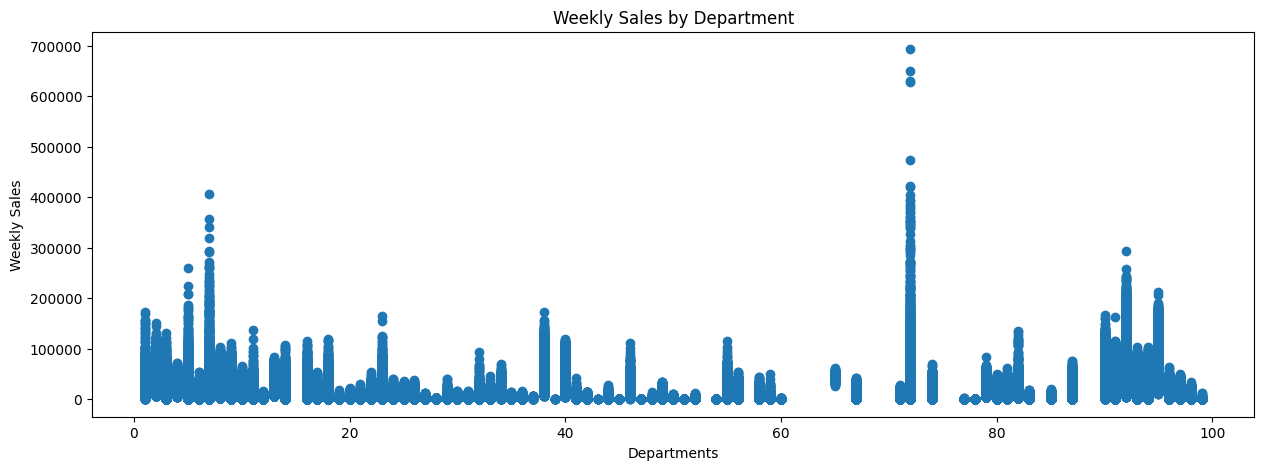

In [19]:
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Department')
plt.xlabel('Departments')
plt.ylabel('Weekly Sales')
plt.scatter(x= df['Dept'],y =df['Weekly_Sales'])
plt.show()


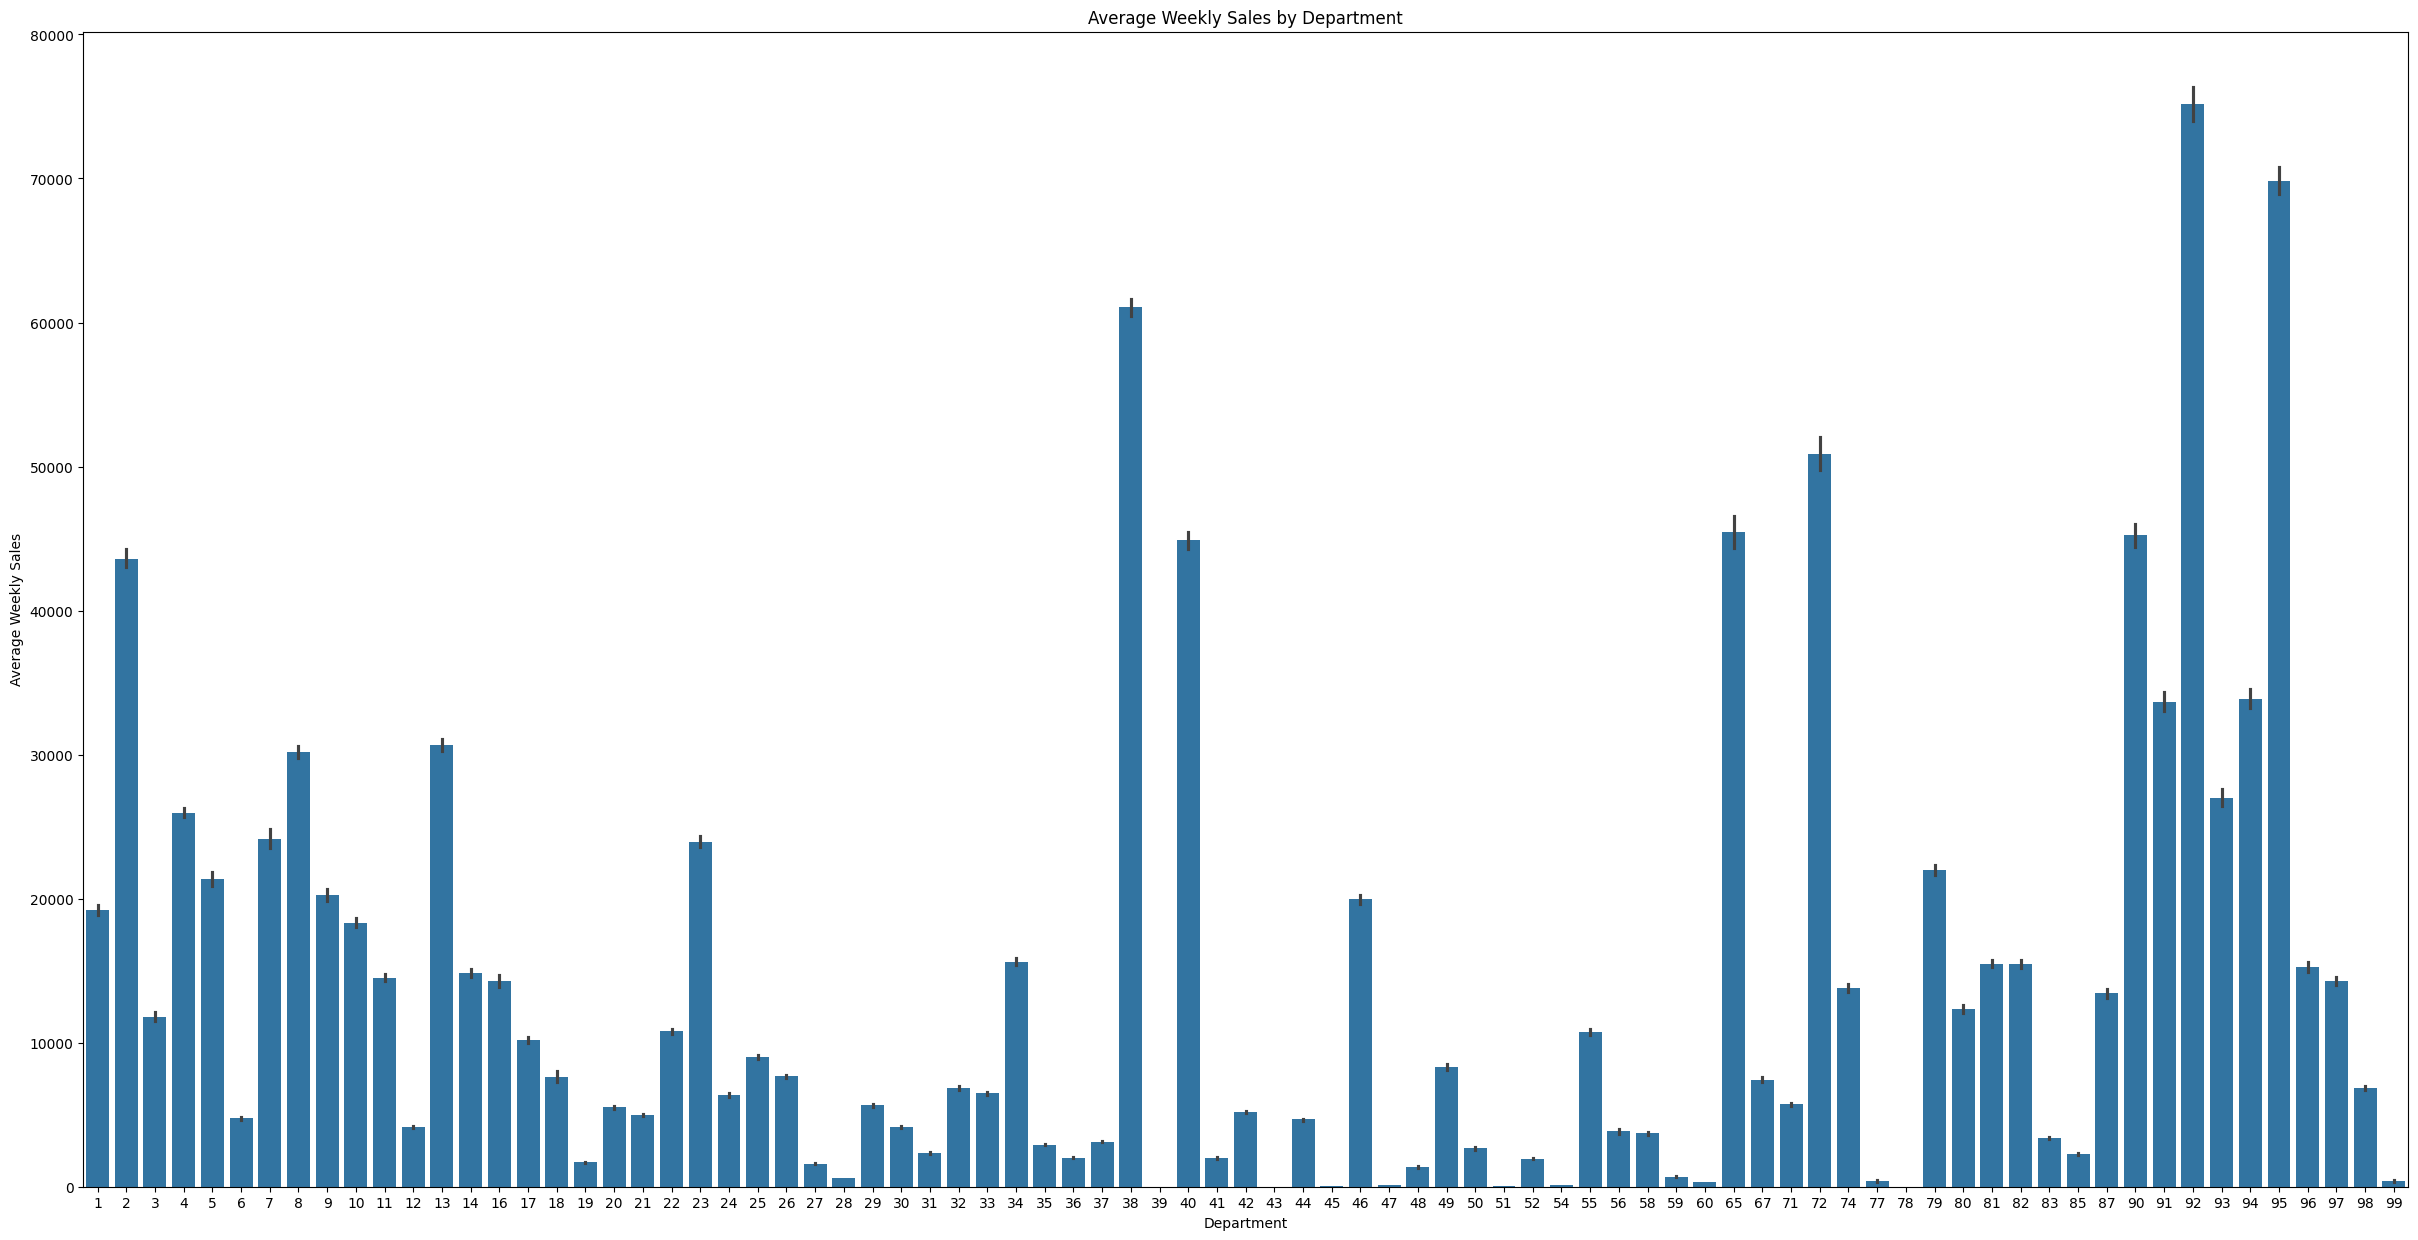

In [ ]:
plt.figure(figsize=(30,15))
fig = sns.barplot(x='Dept', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales by Department')
plt.xlabel('Department')
plt.ylabel('Average Weekly Sales')
plt.show()

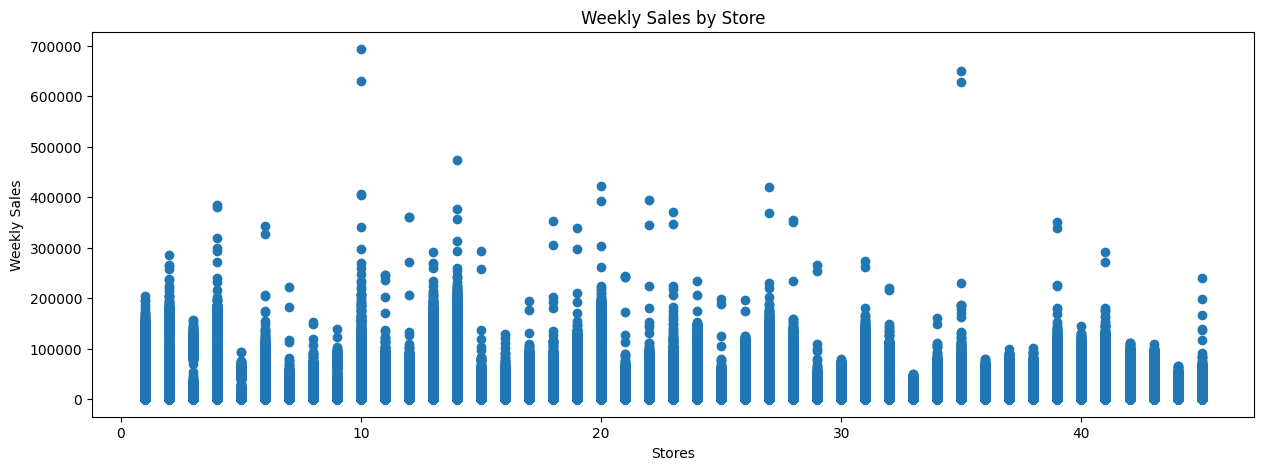

In [26]:
plt.figure(figsize=(15,5))
plt.title('Weekly Sales by Store')
plt.xlabel('Stores')
plt.ylabel('Weekly Sales')
plt.scatter(x = df['Store'],y = df['Weekly_Sales'])
plt.show()

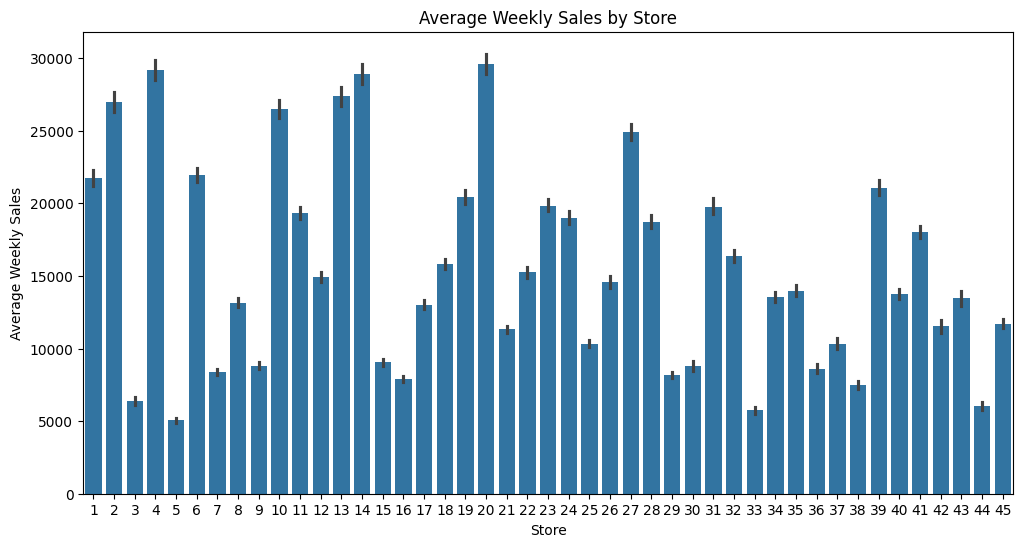

In [27]:
plt.figure(figsize=(12,6))
fig = sns.barplot(x='Store', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales by Store')
plt.xlabel('Store')
plt.ylabel('Average Weekly Sales')
plt.show()

### 4.4 Temporal Feature Extraction
Extracting time-based features from the Date column.

In [19]:
df["Date"] = pd.to_datetime(df["Date"])
df['Week'] = df['Date'].dt.isocalendar().week
df['Month'] =df['Date'].dt.month
df['Year'] =df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [20]:
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Labor_Day,Super_Bowl,Thanksgiving,Christmas,Week,Month,Year,Day,DayOfWeek
0,1,1,2010-02-05,24924.50,False,42.31,2.572,211.096358,8.106,A,151315,False,False,False,False,5,2,2010,5,4
1,1,1,2010-02-12,46039.49,True,38.51,2.548,211.242170,8.106,A,151315,False,True,False,False,6,2,2010,12,4
2,1,1,2010-02-19,41595.55,False,39.93,2.514,211.289143,8.106,A,151315,False,False,False,False,7,2,2010,19,4
3,1,1,2010-02-26,19403.54,False,46.63,2.561,211.319643,8.106,A,151315,False,False,False,False,8,2,2010,26,4
4,1,1,2010-03-05,21827.90,False,46.50,2.625,211.350143,8.106,A,151315,False,False,False,False,9,3,2010,5,4


### 4.5 Monthly & Yearly Sales Patterns
Analyzing sales trends by month and year.

In [21]:
df.groupby('Month')['Weekly_Sales'].mean()

Month
1     14182.239153
2     16048.701191
3     15464.817698
4     15696.435193
5     15845.556200
6     16397.605478
7     15905.472425
8     16113.800069
9     15147.216063
10    15279.182119
11    17534.964277
12    19425.798603
Name: Weekly_Sales, dtype: float64

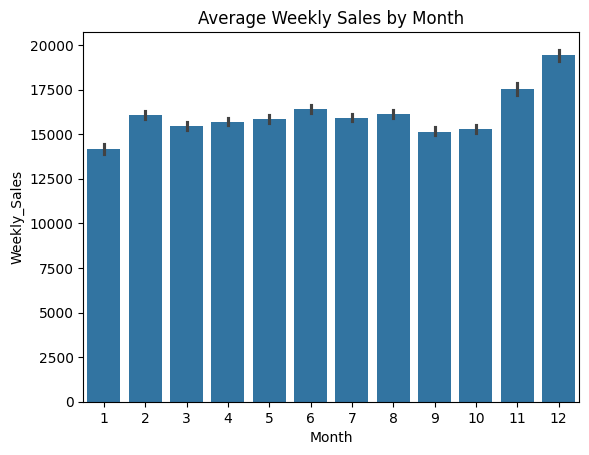

In [31]:
fig = sns.barplot(x='Month', y='Weekly_Sales', data=df)
plt.title('Average Weekly Sales by Month')
plt.show()

In [22]:
df.groupby('Year')['Weekly_Sales'].mean()


Year
2010    16318.648285
2011    16007.797985
2012    15748.265005
Name: Weekly_Sales, dtype: float64

In [23]:
df.groupby('Week')['Weekly_Sales'].mean().sort_values(ascending=False).head()


Week
51    26454.164116
47    22269.601768
50    20478.421134
49    18731.794840
22    16856.650245
Name: Weekly_Sales, dtype: float64

In [24]:
df.groupby('IsHoliday')['Weekly_Sales'].mean()


IsHoliday
False    15952.816352
True     17094.300918
Name: Weekly_Sales, dtype: float64

### 4.6 Correlation Analysis
Examining relationships between features and weekly sales.

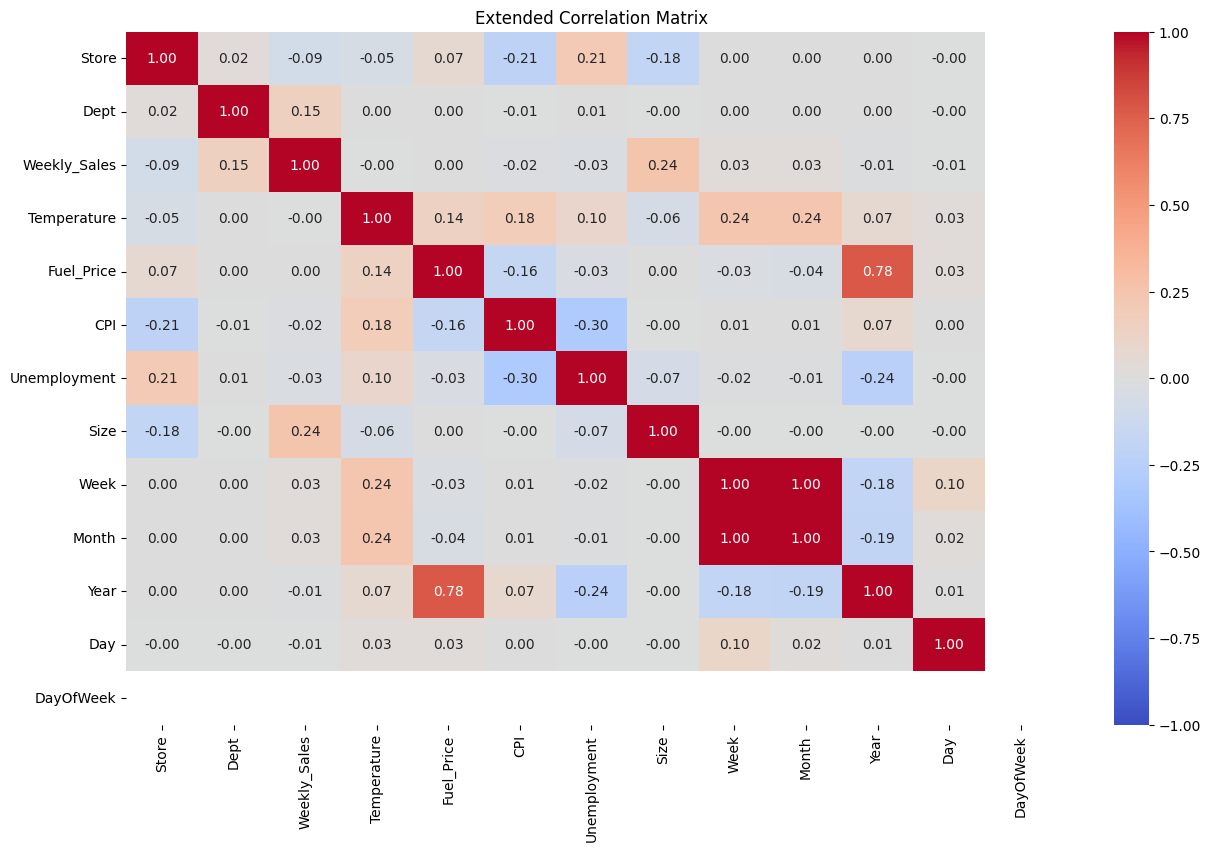

In [25]:
numeric_df = df.select_dtypes(include='number').copy()
corr = numeric_df.corr()
plt.figure(figsize=(15,9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Extended Correlation Matrix')
plt.show()


### 4.7 Weekly Sales Trends Over Time
Visualizing sales patterns across weeks and years.

<Axes: title={'center': 'Weekly Sales by Year'}, xlabel='Week Number', ylabel='Average Weekly Sales'>

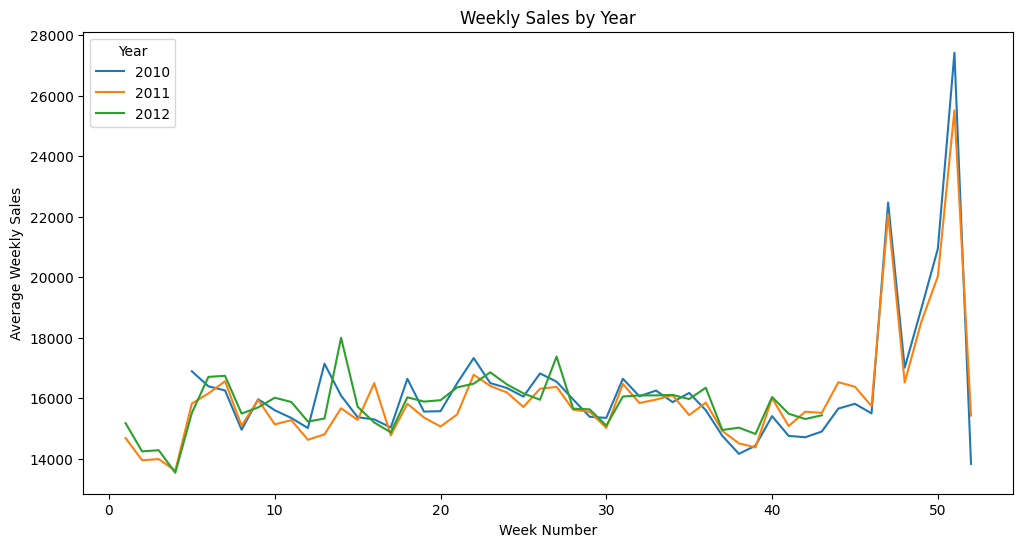

In [26]:
weekly=df.groupby(['Year', 'Week'])['Weekly_Sales'].mean().unstack(0)
weekly.columns.name = 'Year'
weekly.index.name = 'Week'
weekly.plot(figsize=(12,6), title='Weekly Sales by Year', xlabel='Week Number', ylabel='Average Weekly Sales')


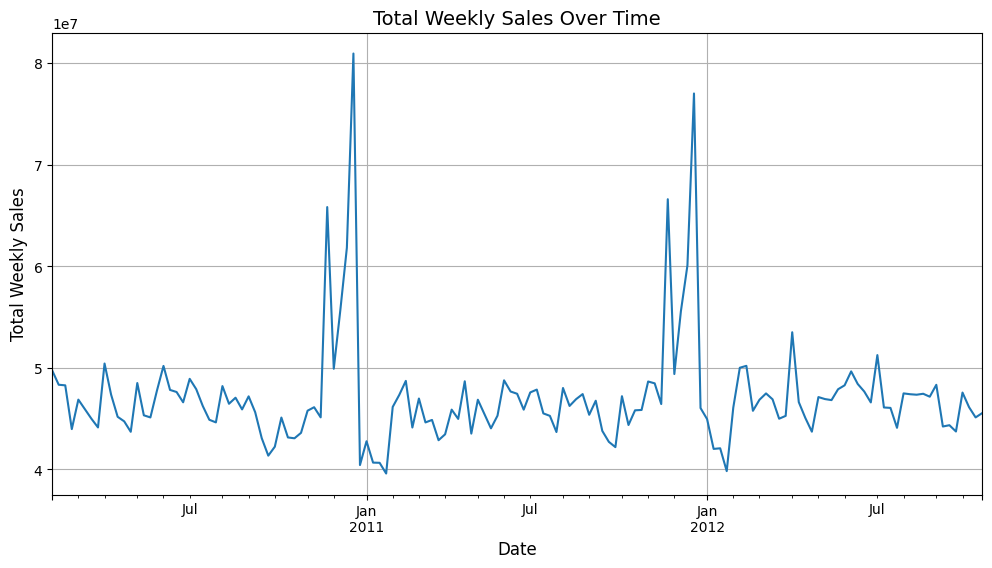

In [27]:
df = df.sort_values('Date')
df.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(12,6))
plt.title("Total Weekly Sales Over Time", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Total Weekly Sales", fontsize=12)
plt.grid(True)
plt.show()


### 4.8 Interactive Dashboard
Building an interactive visualization dashboard using Plotly Dash to explore relationships between sales and external factors.

In [ ]:
df_grouped = df.groupby('Date', as_index=False).agg({
    'Weekly_Sales': 'sum',
    'Temperature': 'mean',
    'Fuel_Price': 'mean',
    'CPI': 'mean',
    'Unemployment': 'mean'
})


app = Dash(__name__)

external_factors = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

app.layout = html.Div([
    html.H1("Sales vs External Factors",
            style={'text-align': 'center', 'margin-bottom': '30px', 'color': '#2c3e50'}),

    html.Div([
        html.Label("Select External Factor:", style={'font-weight': 'bold'}),
        dcc.Dropdown(
            id='factor-dropdown',
            options=[{'label': f, 'value': f} for f in external_factors],
            value=external_factors[0],
            clearable=False
        )
    ], style={'width': '40%', 'margin': '0 auto', 'padding': '10px',
              'background-color': '#f8f9fa', 'border-radius': '10px',
              'margin-bottom': '30px'}),

    dcc.Graph(id='factor-over-time')
])


@app.callback(
    Output('factor-over-time', 'figure'),
    Input('factor-dropdown', 'value')
)
def update_chart(selected_factor):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df_grouped['Date'], y=df_grouped['Weekly_Sales'],
        mode='lines+markers',
        name='Weekly Sales',
        line=dict(color='#1f77b4', width=3)
    ))
    fig.add_trace(go.Scatter(
        x=df_grouped['Date'], y=df_grouped[selected_factor],
        mode='lines+markers',
        name=selected_factor,
        yaxis='y2',
        line=dict(color='#e67e22', width=2, dash='dot')
    ))

    fig.update_layout(
        title=f"Weekly Sales and {selected_factor} Over Time",
        xaxis_title="Date",
        yaxis_title="Weekly Sales",
        yaxis2=dict(
            title=selected_factor,
            overlaying='y',
            side='right'
        ),
        template='plotly_white',
        height=600,
        legend=dict(x=0.01, y=0.99)
    )

    return fig



app.run(debug=True)


---

## 5. Data Transformation

### 5.1 Categorical Encoding
Encoding the Store Type column using Label Encoding (A=0, B=1, C=2).

In [29]:
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])

### 5.2 Boolean to Integer Conversion
Converting boolean holiday columns to integer format for model compatibility.

In [30]:
df[df.select_dtypes(bool).columns] = df.select_dtypes(bool).astype(int)

### 5.3 Final Data Preparation
Dropping the Date column, resetting index, and exporting clean data.

In [31]:
df = df.drop(columns=['Date'])

In [32]:
df = df.reset_index(drop=True)

In [33]:
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,Labor_Day,Super_Bowl,Thanksgiving,Christmas,Week,Month,Year,Day,DayOfWeek
0,1,1,24924.50,0,42.31,2.572,211.096358,8.106,0,151315,0,0,0,0,5,2,2010,5,4
1,15,21,3253.19,0,19.83,2.954,131.527903,8.350,1,123737,0,0,0,0,5,2,2010,5,4
2,15,20,4606.90,0,19.83,2.954,131.527903,8.350,1,123737,0,0,0,0,5,2,2010,5,4
3,15,19,1381.40,0,19.83,2.954,131.527903,8.350,1,123737,0,0,0,0,5,2,2010,5,4
4,15,18,2239.25,0,19.83,2.954,131.527903,8.350,1,123737,0,0,0,0,5,2,2010,5,4


---

## 6. Model Training & Evaluation

### 6.1 Train-Test Split
Splitting the data into training (80%) and testing (20%) sets.

In [34]:
X = df.drop('Weekly_Sales', axis=1)
y = df['Weekly_Sales']

---

## 7. MLflow Experiment Tracking

### 7.1 MLflow Setup Functions
Defining helper functions for creating and retrieving MLflow experiments.

In [35]:
def create_mlflow_experiment(
        experiment_name : str ,
        artifact_location : str,
        tags : dict[str,Any]
):
    try: 
        exp_id = mlflow.create_experiment(
            name = experiment_name,
            artifact_location=artifact_location,
            tags = tags
        )
    except:
        print(f"Experiment :{experiment_name} , Already exists.")
        exp_id = mlflow.get_experiment_by_name(experiment_name).experiment_id
    return exp_id
        

### 7.2 Create Experiment
Creating an MLflow experiment to track all runs.

In [36]:
exp_id = create_mlflow_experiment(
    experiment_name="Walmart_Sales_Forecasting_3",
    artifact_location="mlflow_artifacts",
    tags= {"Author": "Anton Reda",
        "Project": "Walmart Sales Forecasting",
        "Version": "1.0"}

)
print(f"Experiment id {exp_id}")

Experiment id 399713842860766921


C:\Users\besho\AppData\Roaming\Python\Python311\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning:

Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534



In [39]:
def get_mlflow_experiment(
        experiment_name : str = None,
        experiment_id : str = None
) -> mlflow.entities.Experiment:
        if experiment_id is not None:
            exp = mlflow.get_experiment(experiment_id)
        elif experiment_name is not None:
            exp = mlflow.get_experiment_by_name(experiment_name)
        else:
            raise ValueError("Either experiment_name or experiment_id must be provided.")
        return exp 


### 7.3 Verify Experiment
Confirming the experiment was created successfully.

In [ ]:
exp = get_mlflow_experiment(experiment_id=exp_id)
print(f"name : {exp.name}")
print(f"artifact_location : {exp.artifact_location}")
print(f"tags : {exp.tags}")


name : Walmart_Sales_Forecasting_3
artifact_location : file:///d:/anton/DEPI/IBM Data Scientist/0- Graduation Project/project/mlflow_artifacts
tags : {'Author': 'Anton Reda', 'Project': 'Walmart Sales Forecasting', 'Version': '1.0'}


### 7.4 Model Training with MLflow Tracking
Training XGBoost model while logging parameters, metrics, and artifacts to MLflow.

**Model Configuration:**
- Objective: reg:squarederror
- N Estimators: 300
- Learning Rate: 0.2
- Max Depth: 7
- Subsample: 0.8

In [40]:
model_name = "XGBRegressor"
first_run_id = None

with mlflow.start_run(run_name= "xgb_model_1", experiment_id=exp_id) as run:
    first_run_id = run.info.run_id

    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 300,
        'learning_rate': 0.2,
        'max_depth': 7,
        'subsample': 0.8,
        'random_state': 42
    }

    mlflow.log_params(params)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    external_cols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']
    scaler = StandardScaler()

    X_train[external_cols] = scaler.fit_transform(X_train[external_cols]) 
    X_test[external_cols] = scaler.transform(X_test[external_cols]) 
 
    xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=300, learning_rate=0.2, max_depth=7, subsample=0.8, random_state=42)
    xgb_model.fit(X_train, y_train)

    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)


    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)

    metrics = {
        "R2_Score": r2,
        "MSE_Train": mse_train,
        "MSE_Test": mse_test,
        "RMSE_Train": rmse_train,
        "RMSE_Test": rmse_test
    }
    mlflow.log_metrics(metrics)   
        
    print(f"R² Score: {r2:.4f}")
    print(f"Training MSE: {mse_train:,.2f}")
    print(f"Testing MSE: {mse_test:,.2f}")
    print(f"Training RMSE: ${rmse_train:,.2f}")  # In dollars
    print(f"Testing RMSE: ${rmse_test:,.2f}")    # In dollars

    mlflow.sklearn.log_model(
           sk_model=xgb_model,
           artifact_path="xgb_model_1",  # Use 'name' instead of 'artifact_path'
           registered_model_name="XGBRegressor_Walmart_Sales_Forecasting",
           signature=mlflow.models.infer_signature(X_train, y_pred_test)
    )

R² Score: 0.9737
Training MSE: 9,192,268.41
Testing MSE: 13,712,847.71
Training RMSE: $3,031.88
Testing RMSE: $3,703.09


C:\Users\besho\AppData\Roaming\Python\Python311\site-packages\mlflow\types\utils.py:452: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

2025/11/29 01:19:30 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Users\besho\AppData\Roaming\Python\Python311\site-packages\mlflow\tracking\_model_registry\utils.py:215: FutureWarning:

Filesystem

### 7.5 Hyperparameter Tuning
Using GridSearchCV with 3-fold cross-validation to find the optimal XGBoost hyperparameters.

**Parameter Grid:**
- n_estimators: [100, 200, 300]
- max_depth: [3, 5, 7]
- learning_rate: [0.01, 0.1, 0.2]
- subsample: [0.8, 1.0]

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    xgb, param_grid, 
    cv=3, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best RMSE: ${-grid_search.best_score_:,.2f}")

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Best RMSE: $3,793.25


---

## 8. Model Visualization & Results

### 8.1 Feature Importance
Identifying the most important features for sales prediction.

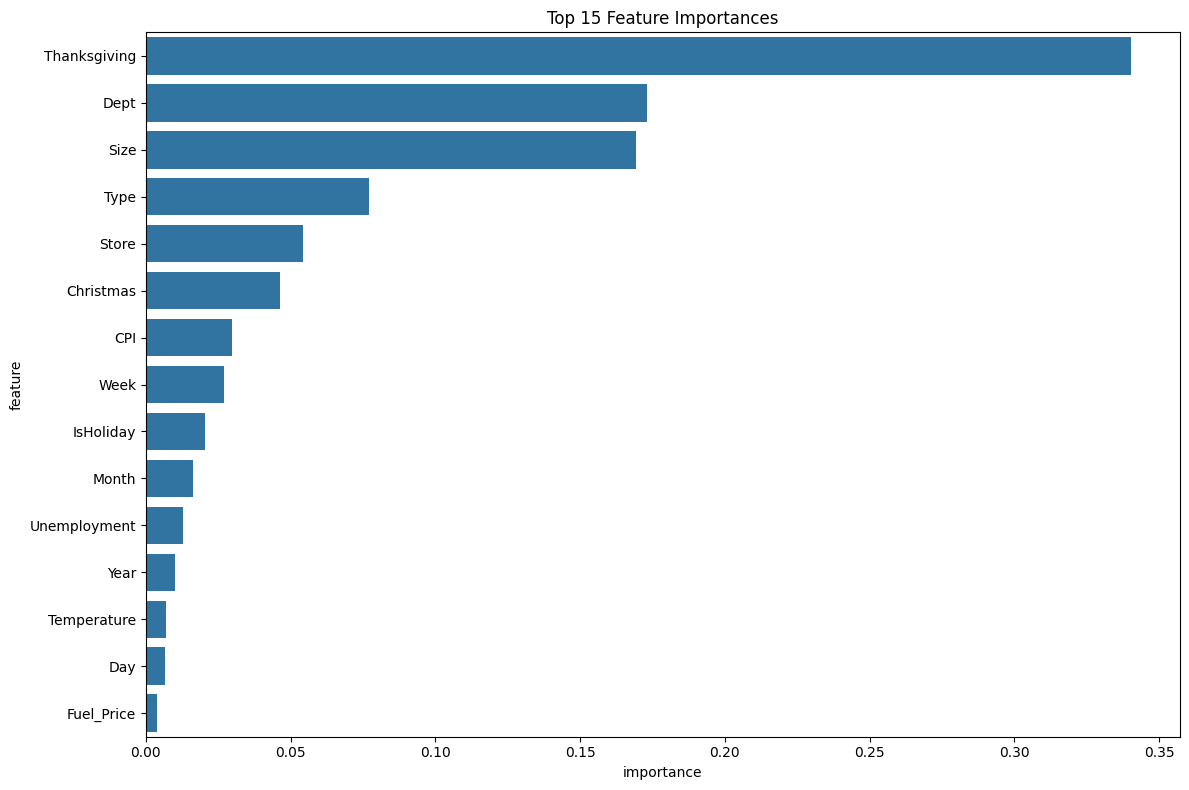

In [ ]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

### 8.2 Predicted vs Actual Sales
Visualizing the model's prediction accuracy.


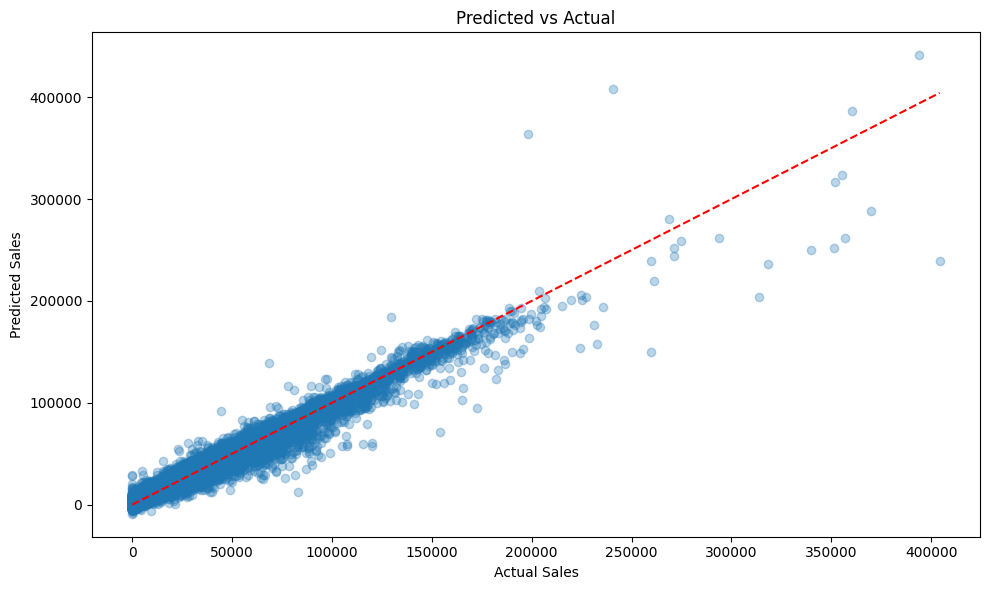

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_preds_xgb, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()


---

## 9. Conclusion

### Key Findings:
- **R² Score:** 0.9737 (97.37% variance explained)
- **Top Predictors:** Department, Store, Size, and temporal features
- **Holiday Impact:** Thanksgiving shows the highest sales boost (~38%)
- **External Factors:** Minimal impact on sales predictions

### Next Steps:
1. Deploy model as real-time prediction API
2. Implement automated retraining pipeline
3. Add weather data for improved accuracy
4. Develop monitoring dashboard for production